In [137]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st
import math

In [145]:
df = pd.read_excel("data/Nile.xlsx", index_col=0)
df.head()
# df.Nile.copy().to_list()

,Nile
1871,1120
1872,1160
1873,963
1874,1210
1875,1160


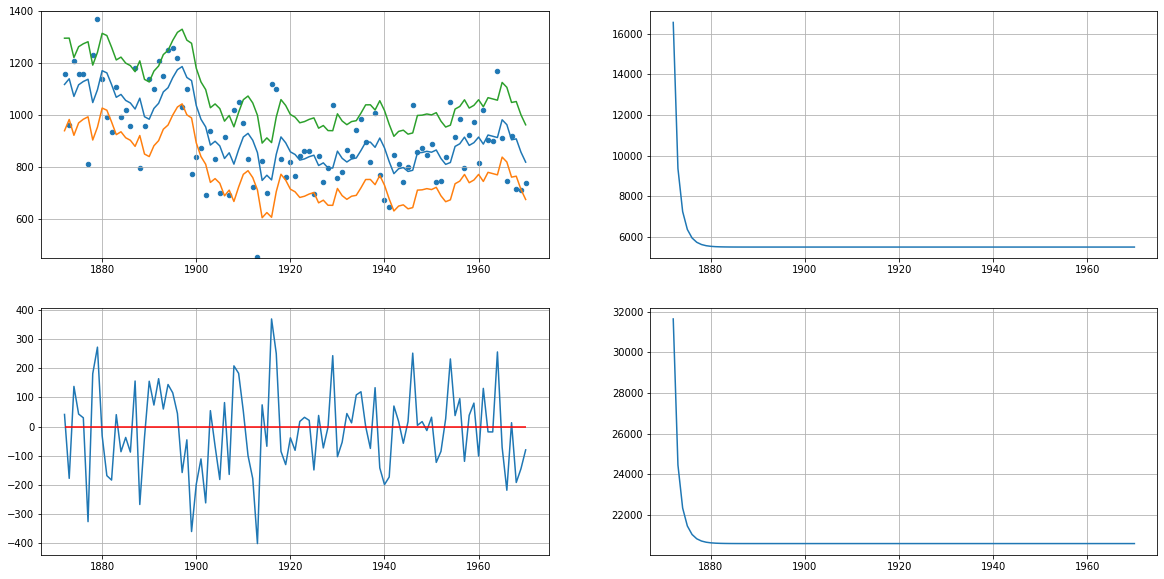

In [173]:
def Kalman_filter(series:pd.Series, P1:float, a1:float, s2_e:float, s2_n:float):
    y_list = series.copy().to_list()
    r = pd.DataFrame(columns=['a', 'P', 'v', 'F', 'K', 'ci'])
    
    a = a1
    P = P1
    # v = F = K = np.nan
    
    for i,y in enumerate(y_list):
        
        # compute all variables
        v = y - a
        F = P + s2_e
        K = P/F

        # store result for t=i
        r.loc[i] = [a, P, v, F, K, F**.5]
        
        # filtered (nowcasting)
        a_f = a + K * v
        P_f = P * (1 - K)

        # predict for t+1
        a_p = a_f
        P_p = P_f + s2_n

        # store prediction t+1 for next iteration
        a = a_p
        P = P_p

    r["y"] = series.values
    r.index = series.index
    return r

df_kf = Kalman_filter(series = df.Nile, P1=1e7, a1=0, s2_e = 15099, s2_n = 1469.1)
df_kf = df_kf.iloc[1:]

fig, axs = plt.subplots(2,2, figsize=(20,10))

# upper left
ax = axs[0,0]
ax.scatter(df_kf.index, df_kf.y, s=20)
df_kf.a.plot(ax=ax)
(df_kf.a-df_kf.ci).plot(ax=ax)
(df_kf.a+df_kf.ci).plot(ax=ax)
ax.set_ylim(450, 1400)

# lower left
ax = axs[1,0]
ax.plot(df_kf.index, df_kf.v)
ax.hlines(y = 0, xmin= df_kf.index.min(), xmax=df_kf.index.max(), color = 'r', linestyle = '-')

# upper right
ax = axs[0,1]
ax.plot(df_kf.index, df_kf.P)


# lower right
ax = axs[1,1]
ax.plot(df_kf.index, df_kf.F)

# make nice plot
for row in axs:
    for ax in row:
        ax.grid()
        pass


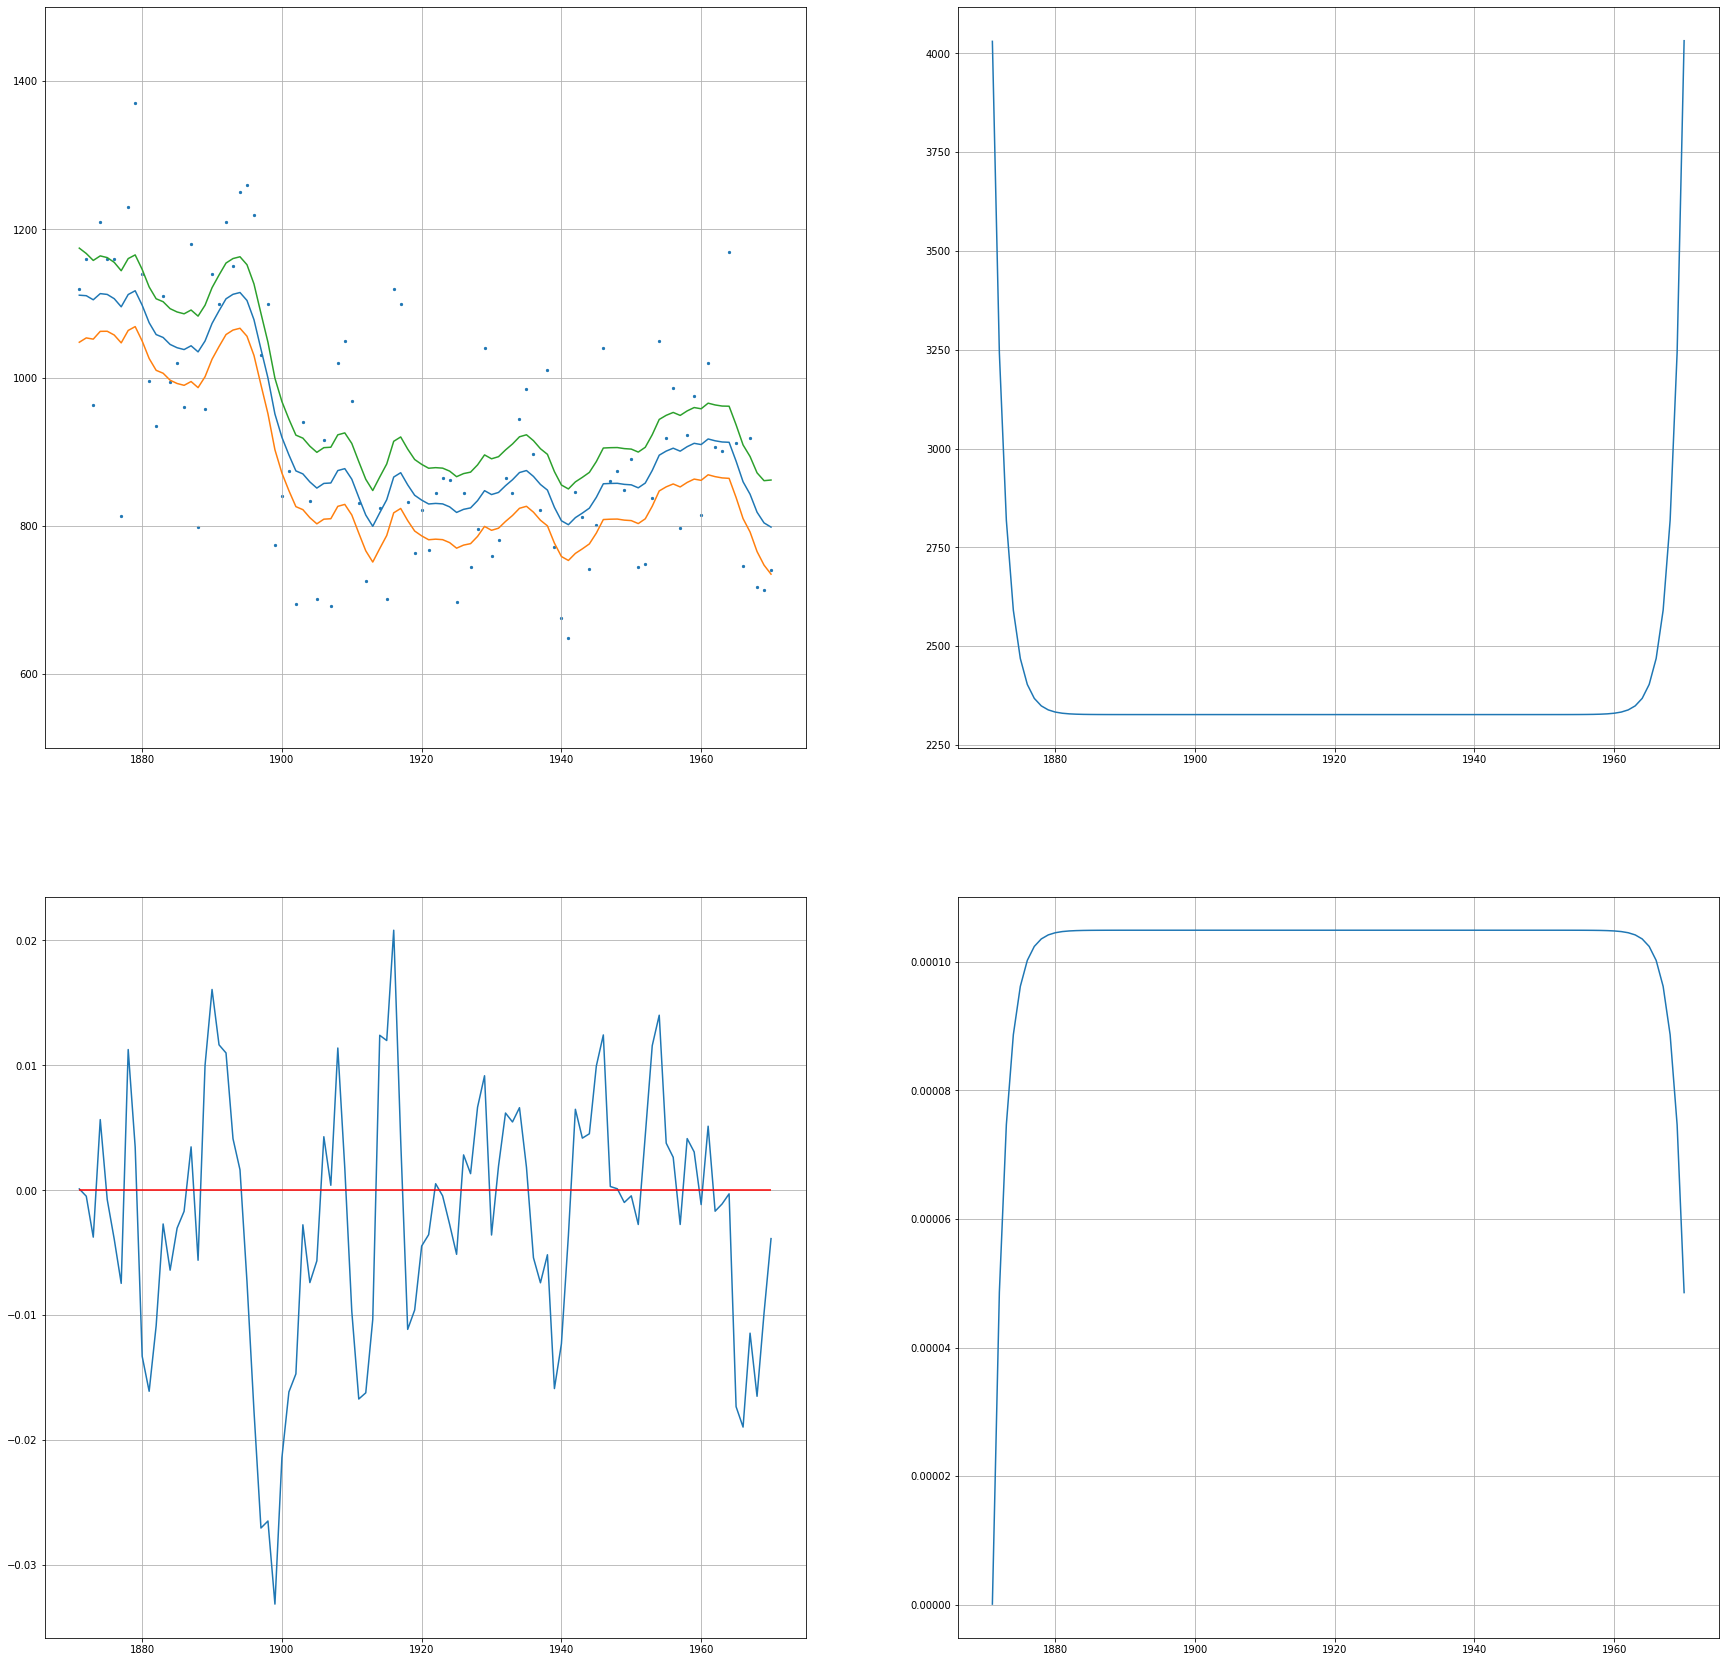

In [175]:
def Kalman_smoother(y: pd.Series, P1: float, a1: float, s2_e: float, s2_n: float, r_n: float, N_n: float):
    df_kf = Kalman_filter(y, P1, a1, s2_e, s2_n)
    ind = df_kf.index
    df_kf = df_kf.iloc[::-1].reset_index(drop=True)
    df_ks = pd.DataFrame(columns=['r', 'a', 'N', 'V', 'err'])

    r = r_n
    N = N_n
    
    for i, row in df_kf.iterrows():
        
        r = row['F']**-1 * row['v'] + (1-row['K'])*r
        a = row['a'] + row['P']*r
        N = row['F']**-1 + (1-row['K'])**2 * N
        V = row['P'] - row['P']**2 * N

        df_ks.loc[i] = [r, a, N, V, V**0.5]
        
    # store existing data
    df_ks["y"] = df_kf["y"]
    add_columns = [c for c in df_kf.columns if c not in df_ks.columns]
    df_ks[add_columns] = df_kf[add_columns]

    df_ks = df_ks.iloc[::-1].reset_index(drop=True)
    df_ks.index = ind
    return df_ks

df_ks = Kalman_smoother(y=df.Nile, P1=10**7, a1=0, s2_e = 15099, s2_n = 1469.1, r_n = 0, N_n = 0)

fig, axs = plt.subplots(2,2, figsize=(30,30))

# upper left
ax = axs[0,0]
ax.scatter(df.index, df.Nile, s=5)
ax.plot(df_ks.index, df_ks.a)
ax.plot(df_ks.index, df_ks.a-df_ks.err)
ax.plot(df_ks.index, df_ks.a+df_ks.err)
ax.set_ylim(500, 1500)

# lower left
ax = axs[1,0]
ax.plot(df_ks.index, df_ks.r)
ax.hlines(y = 0, xmin= df.index.min(), xmax=df.index.max(), color = 'r', linestyle = '-')

# upper right
ax = axs[0,1]
ax.plot(df_ks.index, df_ks.V)


# lower right
ax = axs[1,1]
ax.plot(df_ks.index, df_ks.N)

# make nice plot
for row in axs:
    for ax in row:
        ax.grid()
        pass


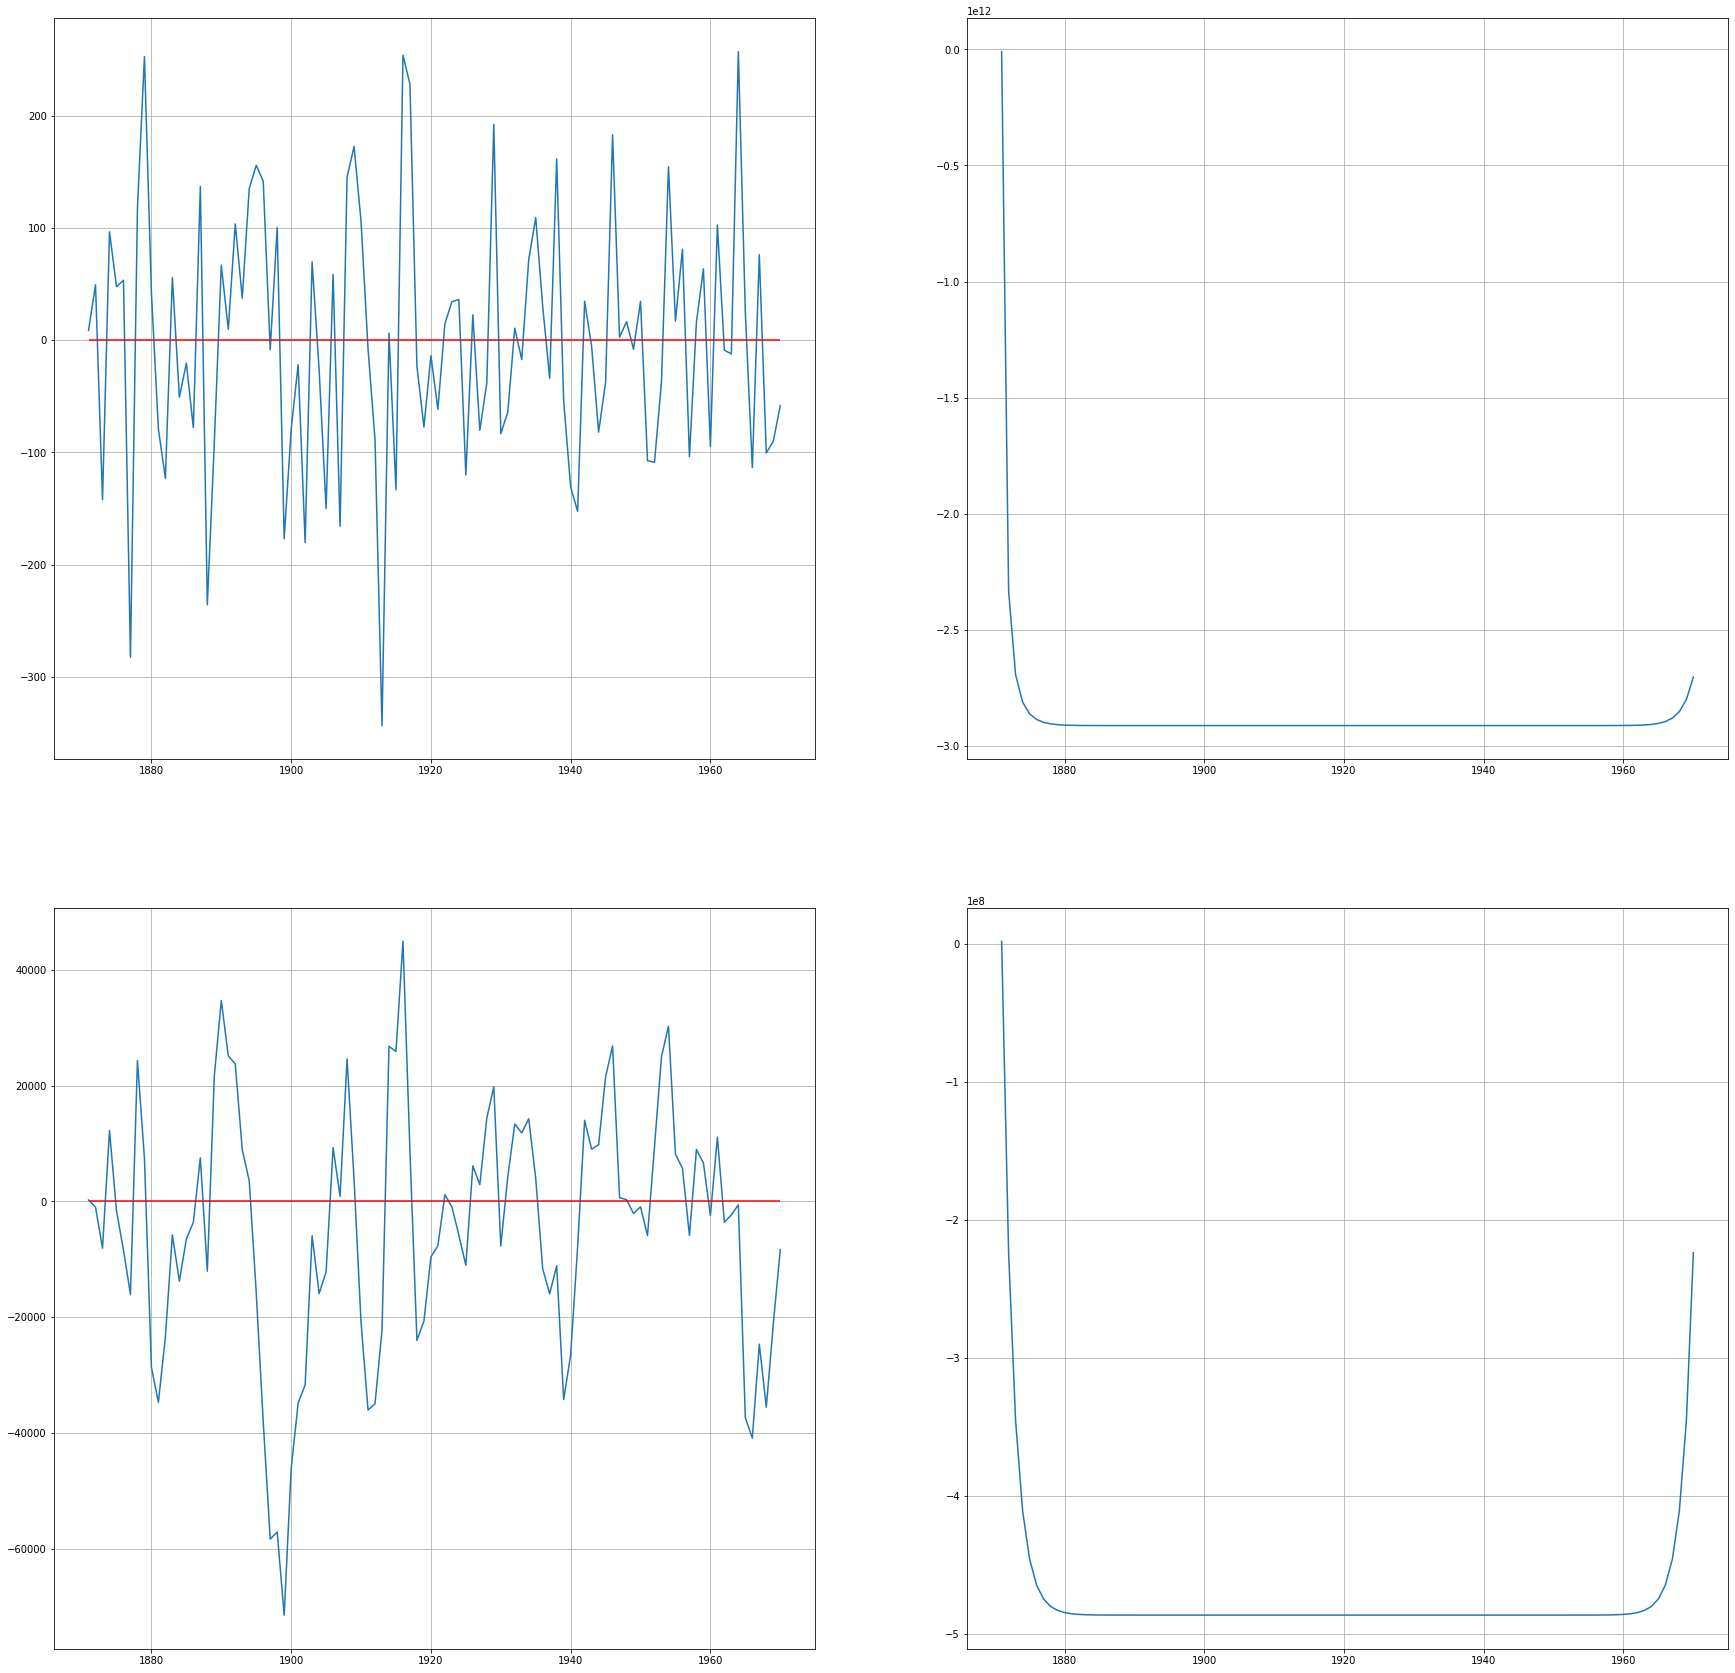

In [179]:
def dist_smoothing(y: pd.Series, P1, a1, s2_e, s2_n, r_int, N_int):
    ind = y.index
    series = y.copy().to_list()
    df_kf = Kalman_filter(y, P1,a1, s2_e, s2_n)
    df_ks = Kalman_smoother(y, P1, a1, s2_e, s2_n, r_int, N_int)
    df_ds = pd.DataFrame(columns=['eps', 'n', 'var_eps', 'var_n'])

    for i, row in df_ks.iterrows():

        eps = row.y - row.a

        D = row.F**(-1) + row.K**2 * row.N
        var_eps = s2_e**2 - s2_e**4 * D
        var_n = s2_n**2 - s2_n**4 * row.N
        n = s2_n**2 * row.r
        
        df_ds.loc[i] = [eps, n, var_eps, var_n]

    df_ds.index = df_ks.index
    df_ds["y"] = df_ks["y"]

    return df_ds

df_ds = dist_smoothing(y=df.Nile, P1=1e7, a1=0, s2_e=15099, s2_n=1469.1, r_int=0, N_int=0)
df_ds
fig, axs = plt.subplots(2,2, figsize=(30,30))

# upper left
ax = axs[0,0]
ax.plot(df_ds.index, df_ds['eps'])
ax.hlines(y = 0, xmin= df.index.min(), xmax=df.index.max(), color = 'r', linestyle = '-')

# lower left
ax = axs[1,0]
ax.plot(df_ds.index[:], df_ds['n'][:])
ax.hlines(y = 0, xmin= df.index.min(), xmax=df.index.max(), color = 'r', linestyle = '-')

# upper right
ax = axs[0,1]
ax.plot(df_ds.index[:], df_ds['var_eps'][:])


# lower right
ax = axs[1,1]
ax.plot(df_ds.index[:], df_ds['var_n'][:])

# make nice plot
for row in axs:
    for ax in row:
        ax.grid()
        pass


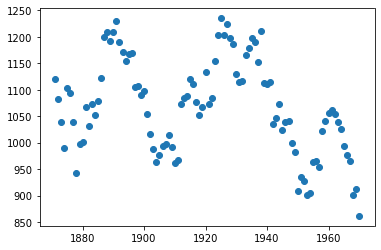

In [68]:
def llm_sim(df, P1, a1, sigma_e, sigma_n, r_int, N_int, a1_plus):

    df_kf = Kalman_filter(df, P1, a1, sigma_e, sigma_n)
    df_ks = Kalman_smoother(df, P1, a1, sigma_e, sigma_n, r_int, N_int)
    df_ds = dist_smoothing(df, P1, a1, sigma_e, sigma_n, r_int, N_int)

    a = a1_plus

    df_llm = pd.DataFrame(columns=['y_sim', 'alpha_plus', 'alpha_kringeltje'])

    for i in range(len(df)):

        eps = np.random.randn() * np.sqrt(sigma_e)
        n = np.random.randn() * np.sqrt(sigma_n)

        y = a + eps

        eps_kringeltje = eps - 
        alpha_kringeltje = df.Nile[i] - eps_kringeltje

        row = [y, a, alpha_kringeltje]
        df_llm.loc[i] = row

        a = a + n

    return df_llm

df_llm = llm_sim(df=df, P1=1e7, a1=0, sigma_e=15099, sigma_n=1469.1, r_int=0, N_int=0, a1_plus=df.Nile[0])


        

In [69]:
print('kf', df_kf.columns)
print('ks', df_ks.columns)
print('ds',df_ds.columns)

kf Index(['a', 'P', 'v', 'F', 'K', 'ci', 'year', 'Nile'], dtype='object')
ks Index(['r', 'alpha', 'N', 'V', 'err', 'year', 'Nile'], dtype='object')
ds Index(['eps', 'n', 'var_eps', 'var_n', 'year', 'Nile'], dtype='object')


In [70]:
df_ks

,r,alpha,N,V,err,year,Nile
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-0.000470,1110.529257,0.000049,3242.056999,56.939064,1872.0,1160.0
2,-0.003747,1105.024860,0.000075,2818.473138,53.089294,1873.0,963.0
3,0.005659,1113.339175,0.000089,2590.916003,50.901041,1874.0,1210.0
4,-0.000742,1112.248601,0.000096,2468.668074,49.685693,1875.0,1160.0
...,...,...,...,...,...,...,...
95,-0.018950,859.504467,0.000100,2468.803438,49.687055,1966.0,746.0
96,-0.011433,842.708974,0.000096,2591.167976,50.903516,1967.0,919.0
97,-0.016485,818.490529,0.000089,2818.942170,53.093711,1968.0,718.0
98,-0.009830,804.049596,0.000075,3242.930073,56.946730,1969.0,714.0


In [167]:
df

,Nile
1871,1120
1872,1160
1873,963
1874,1210
1875,1160
...,...
1966,746
1967,919
1968,718
1969,714
